In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

!pip install -U aeon
!pip install -U imbalanced-learn
from sklearn.linear_model import ElasticNet
from aeon.datasets import load_classification, load_arrow_head
from aeon.classification.deep_learning  import CNNClassifier, MLPClassifier, TapNetClassifier, FCNClassifier
# from torchvision.ops import MLP
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

In [3]:
#print(load_classification(name="GunPoint"))

In [4]:
def load_dataset(PATH):
  loaded_data = np.load(PATH)
  X_train = loaded_data['X_train']
  X_test = loaded_data['X_test']
  y_train = loaded_data['y_train']
  y_test = loaded_data['y_test']
  indices = loaded_data['indices']
  X_train_deq = X_train[indices]
  y_train_deq = y_train[indices]

  return X_train, X_test, X_train_deq, y_train.reshape(y_train.shape[0]), y_test.reshape(y_test.shape[0]), y_train_deq.reshape(y_train_deq.shape[0])

gpds = load_dataset('/content/gunpoint.npz')
gpds[0].shape , gpds[3].shape

((160, 1, 150), (160,))

In [5]:
X_train,X_test,y_train,y_test = gpds[0],gpds[1],gpds[3],gpds[4]
X_train.shape, X_test.shape, type(X_train[0][0][0]), type(y_train[0])

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
print(X_train.shape)

(160, 1, 150)


In [6]:


# Create TensorDatasets for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [7]:


# Create DataLoader instances for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def F_computeAccuracy(hat_y, y):
    """Compute the accuracy

    Parameters
    ----------
    hat_y: (m, 1)
        predicted value by the MLP
    y: (m, 1)
        ground-truth class to predict
    """

    m = y.shape[0]
    class_y = hat_y.detach().numpy().copy()

    class_y[class_y>=0.5]=1
    class_y[class_y<0.5]=0
    return np.sum(class_y==y) / m




In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
class SimpleCNN(nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout_rate)

        dummy_x = torch.zeros(1, 1, num_features)
        dummy_x = self.pool(F.relu(self.conv1(dummy_x)))
        dummy_x = self.pool(F.relu(self.conv2(dummy_x)))
        self._to_linear = dummy_x.numel()  # total number of features after conv and pooling layers

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._to_linear)  # Flatten the tensor
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the CNN classifier
class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_features=None, num_classes=None, lr=0.001):
        self.lr = lr
        self.num_features = num_features
        self.num_classes = num_classes
        if num_features is not None and num_classes is not None:
            self.model = SimpleCNN(num_features, num_classes)
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.1)
        else:
            self.model = None
            self.optimizer = None
            self.scheduler = None
        self.criterion = nn.CrossEntropyLoss()
        # Initialize the histories
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.test_loss_history = []
        self.test_accuracy_history = []

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        if self.model is None:
            self.model = SimpleCNN(self.num_features, self.num_classes)
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.1)
        return self

    def get_params(self, deep=True):
        return {'num_features': self.num_features, 'num_classes': self.num_classes, 'lr': self.lr}

    def fit(self, X, y, X_test=None, y_test=None, num_epochs=100, patience=10):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)
        X_test_tensor = torch.FloatTensor(X_test) if X_test is not None else None
        y_test_tensor = torch.LongTensor(y_test) if y_test is not None else None

        best_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(num_epochs):
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == y_tensor).sum().item()
            train_accuracy = correct / y_tensor.size(0)
            self.train_loss_history.append(loss.item())
            self.train_accuracy_history.append(train_accuracy)

            if X_test_tensor is not None and y_test_tensor is not None:
                self.model.eval()
                with torch.no_grad():
                    test_outputs = self.model(X_test_tensor)
                    test_loss = self.criterion(test_outputs, y_test_tensor)
                    _, predicted = torch.max(test_outputs.data, 1)
                    correct = (predicted == y_test_tensor).sum().item()
                    test_accuracy = correct / y_test_tensor.size(0)
                    self.test_loss_history.append(test_loss.item())
                    self.test_accuracy_history.append(test_accuracy)

                    if test_loss.item() < best_loss:
                        best_loss = test_loss.item()
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1
                        if epochs_no_improve >= patience:
                            print(f'Early stopping at epoch {epoch}')
                            break

        self.plot_loss_accuracy()

    def predict(self, X):
        X_tensor = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            return predicted.numpy()


    def plot_loss_accuracy(self):
        plt.figure(figsize=(12, 8))


        plt.subplot(2, 1, 1)
        plt.plot(self.train_loss_history, label='Training Loss')
        plt.plot(self.test_loss_history, label='Test Loss')
        plt.title('Training and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()


        plt.subplot(2, 1, 2)
        plt.plot(self.train_accuracy_history, label='Training Accuracy')
        plt.plot(self.test_accuracy_history, label='Test Accuracy')
        plt.title('Training and Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()



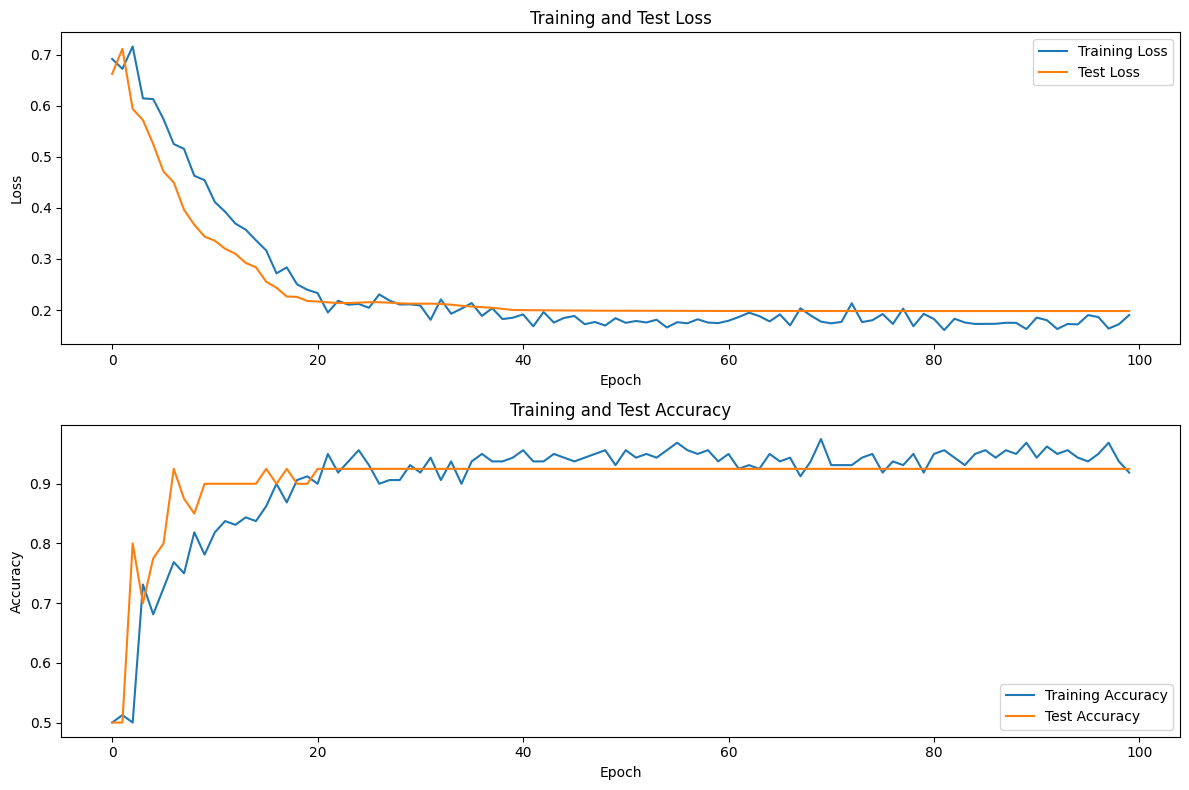

In [10]:
num_features = X_train.shape[2]
num_classes = len(set(y_train))
cnn_classifier = CNNClassifier(num_features=num_features, num_classes=num_classes)

cnn_classifier.fit(X_train, y_train, X_test=X_test, y_test=y_test, num_epochs=100, patience=10)



In [11]:
y_pred = cnn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 0.925


In [12]:
print(num_features)

150


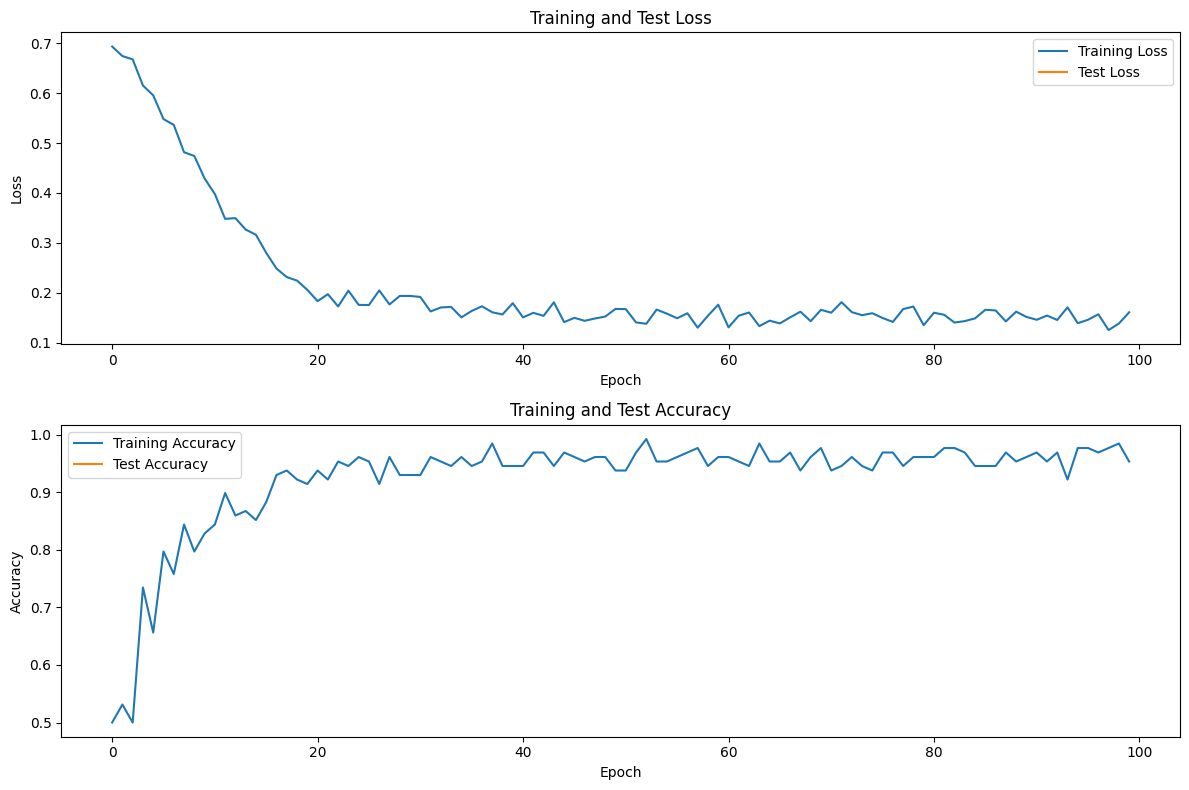

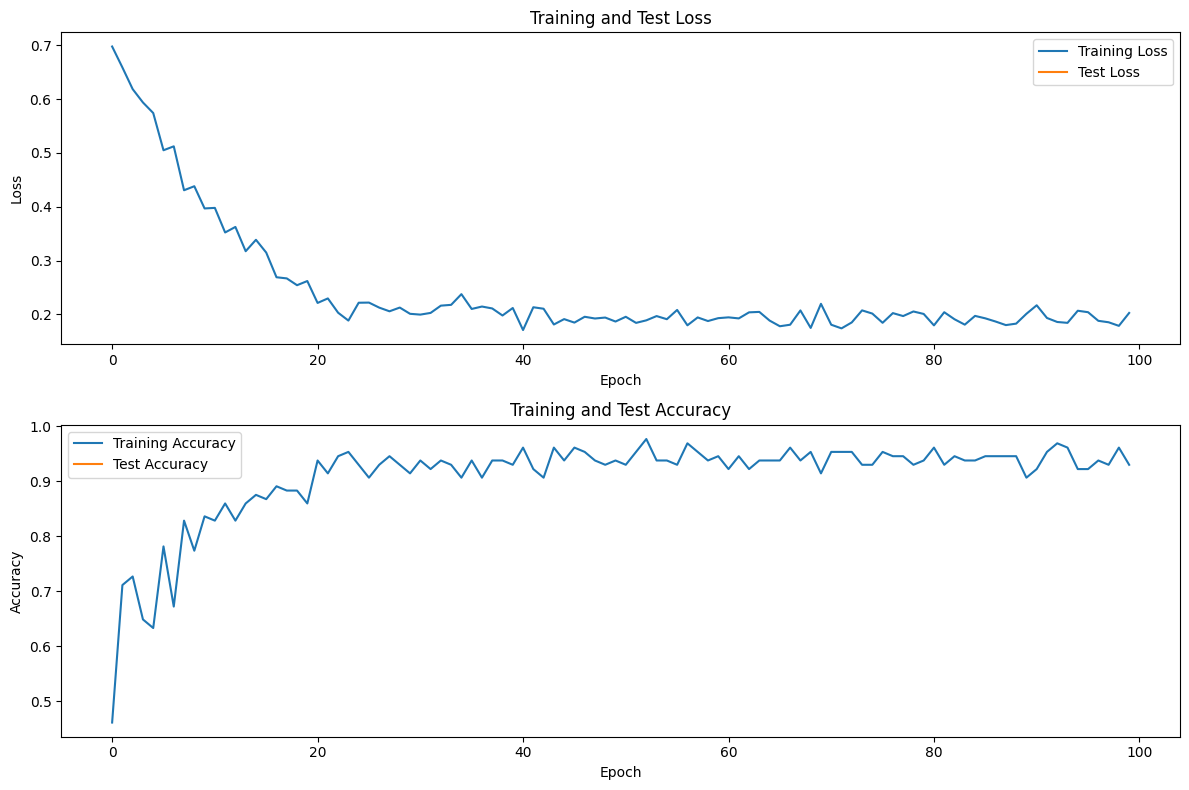

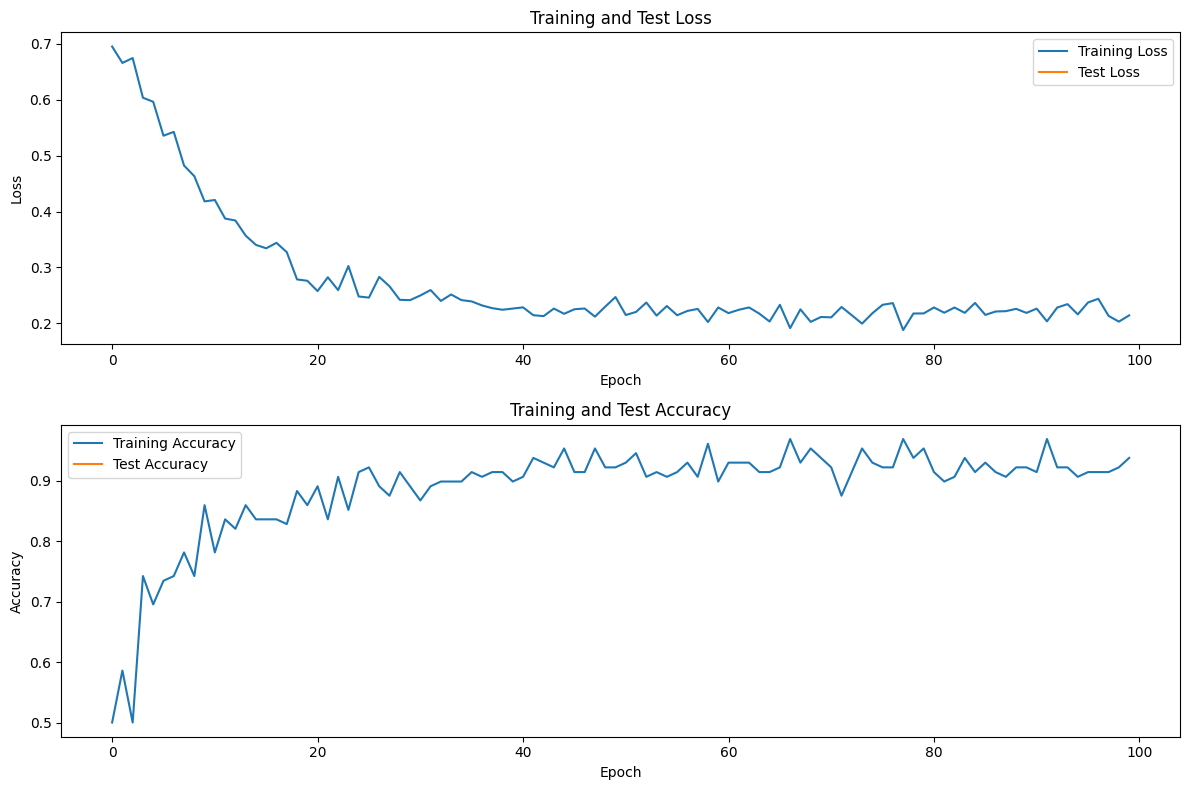

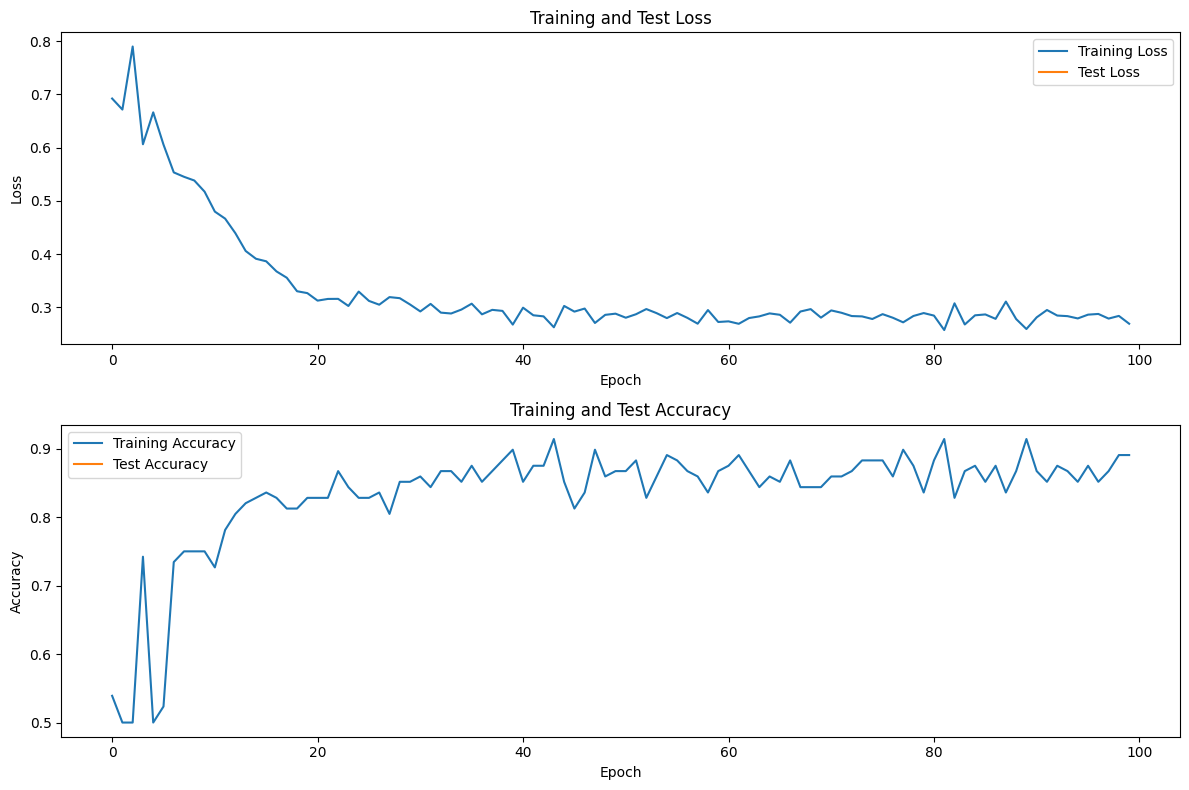

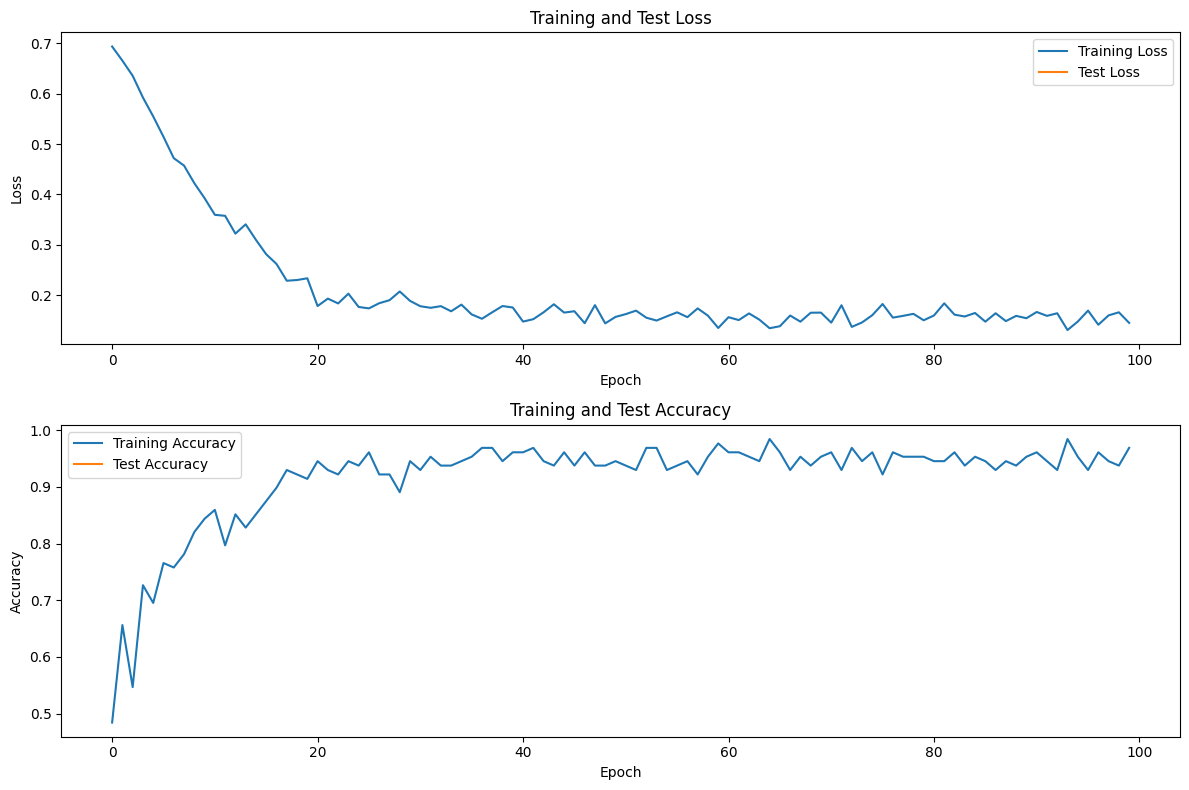

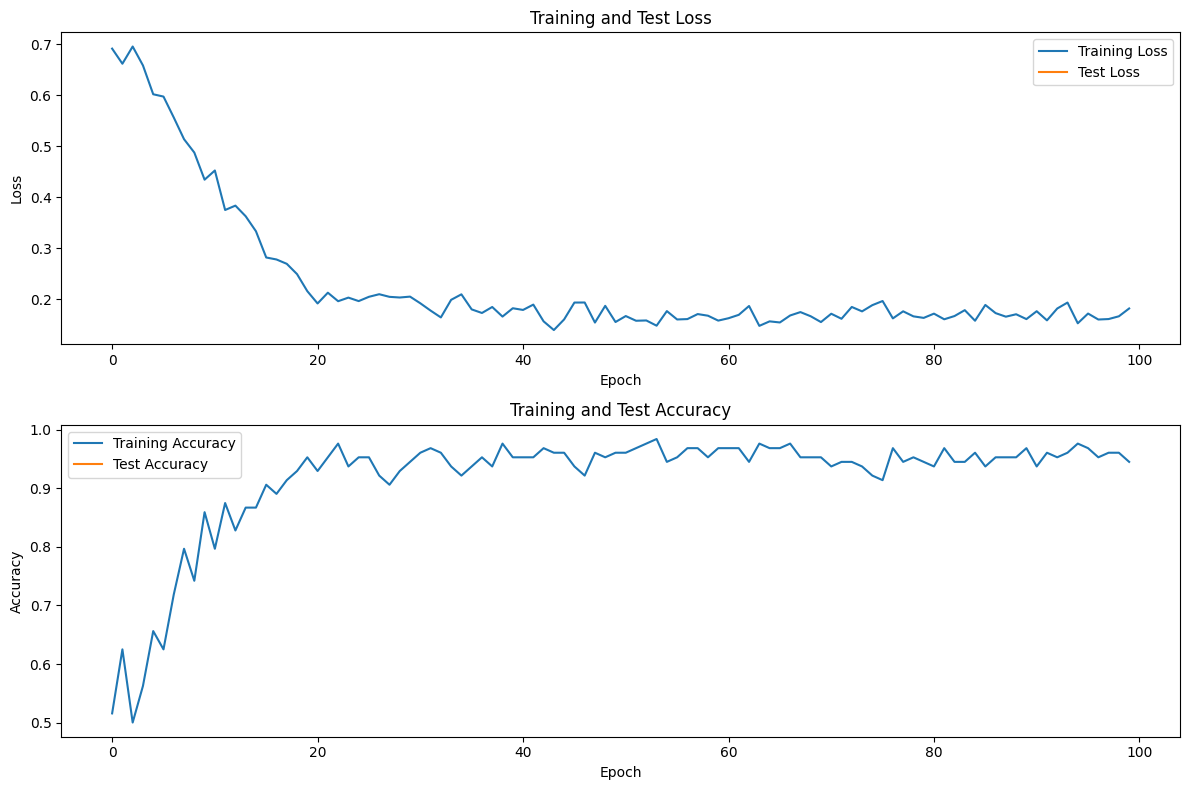

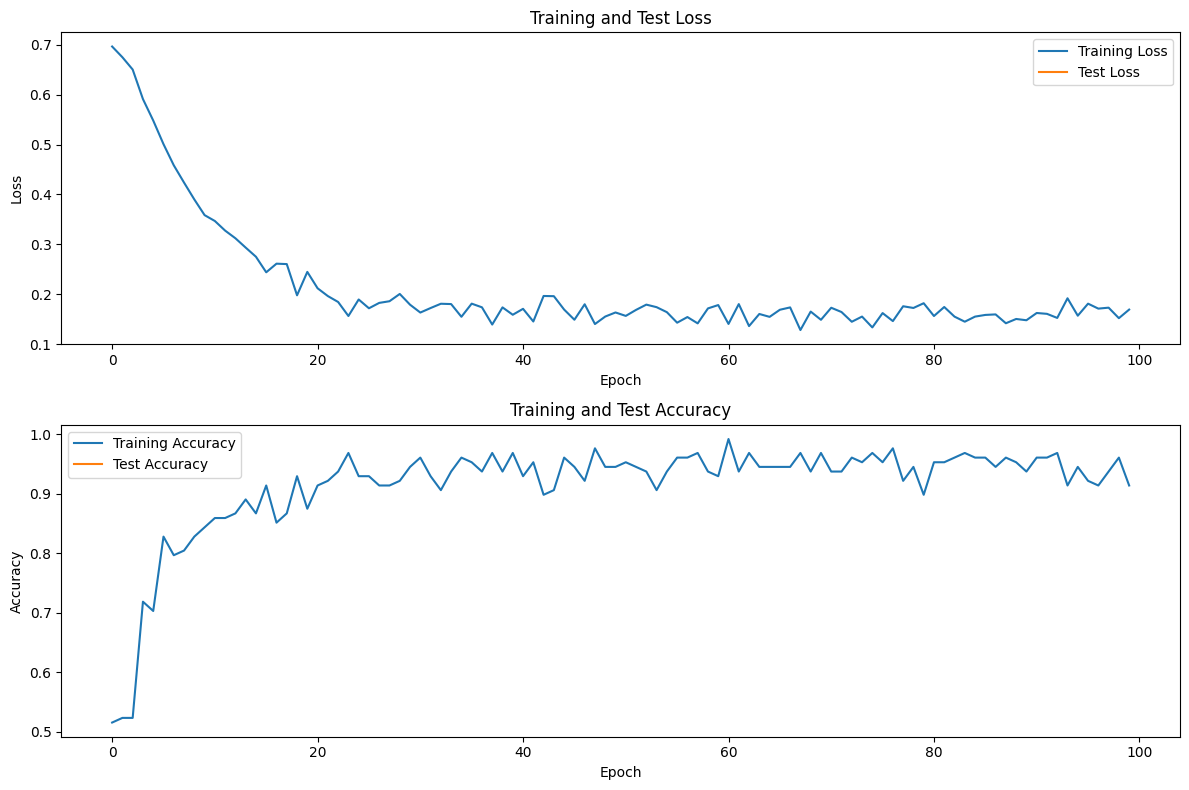

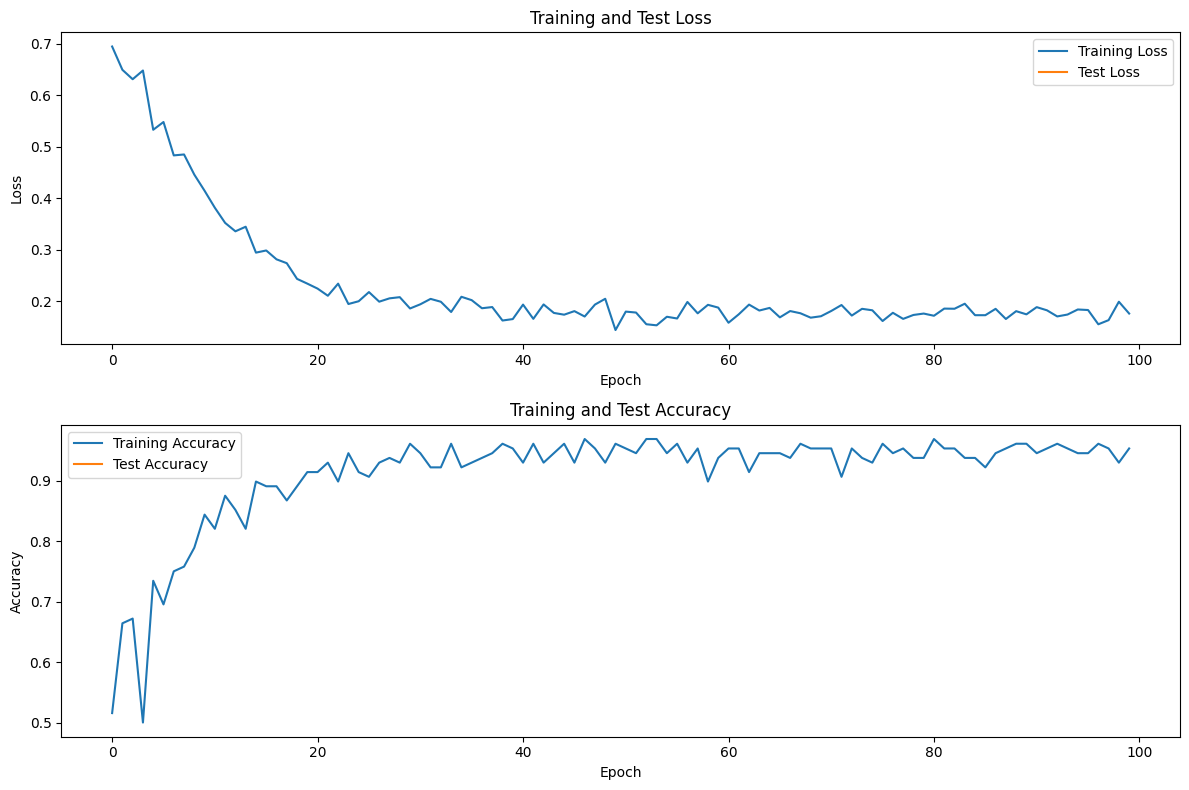

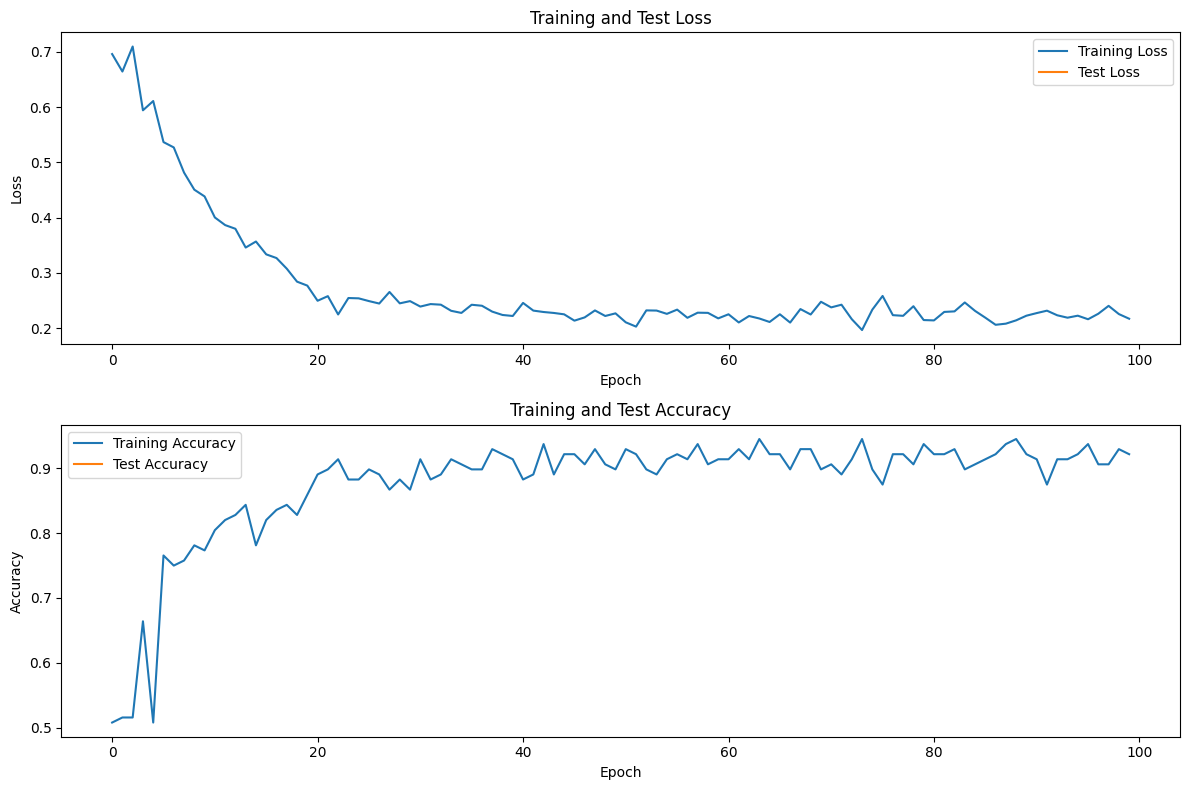

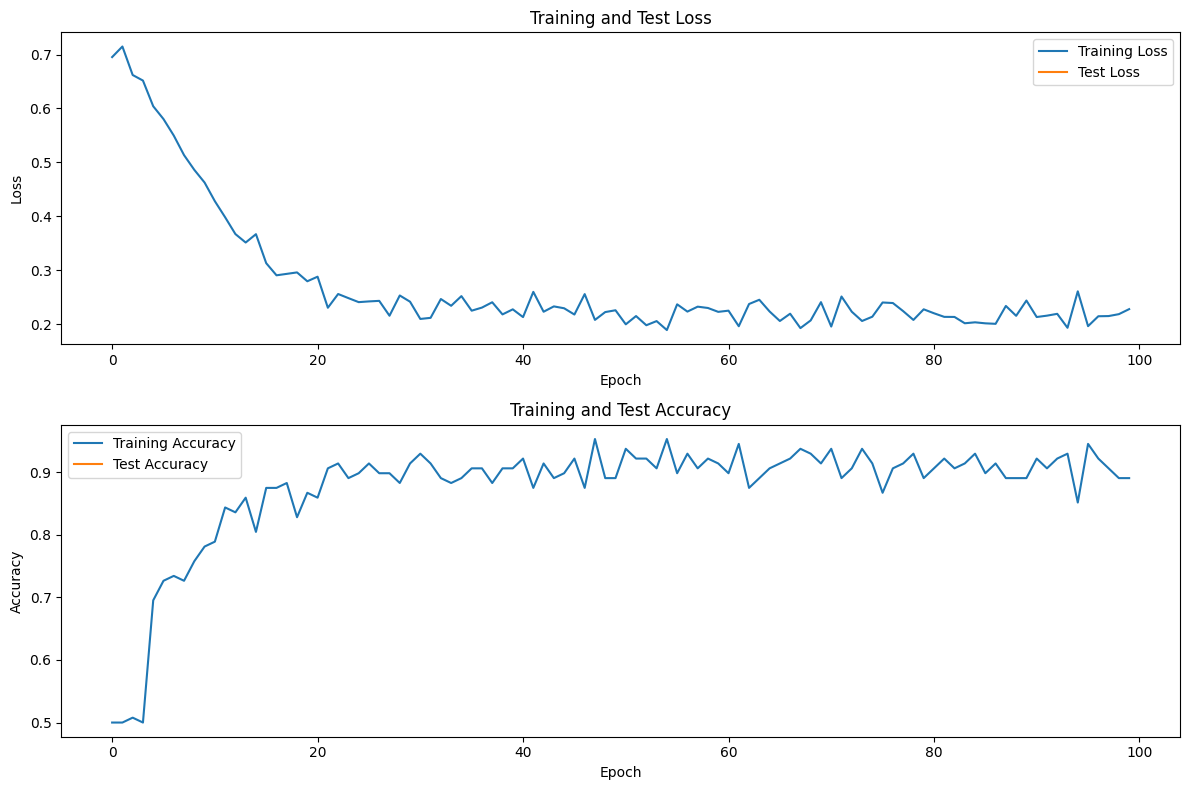

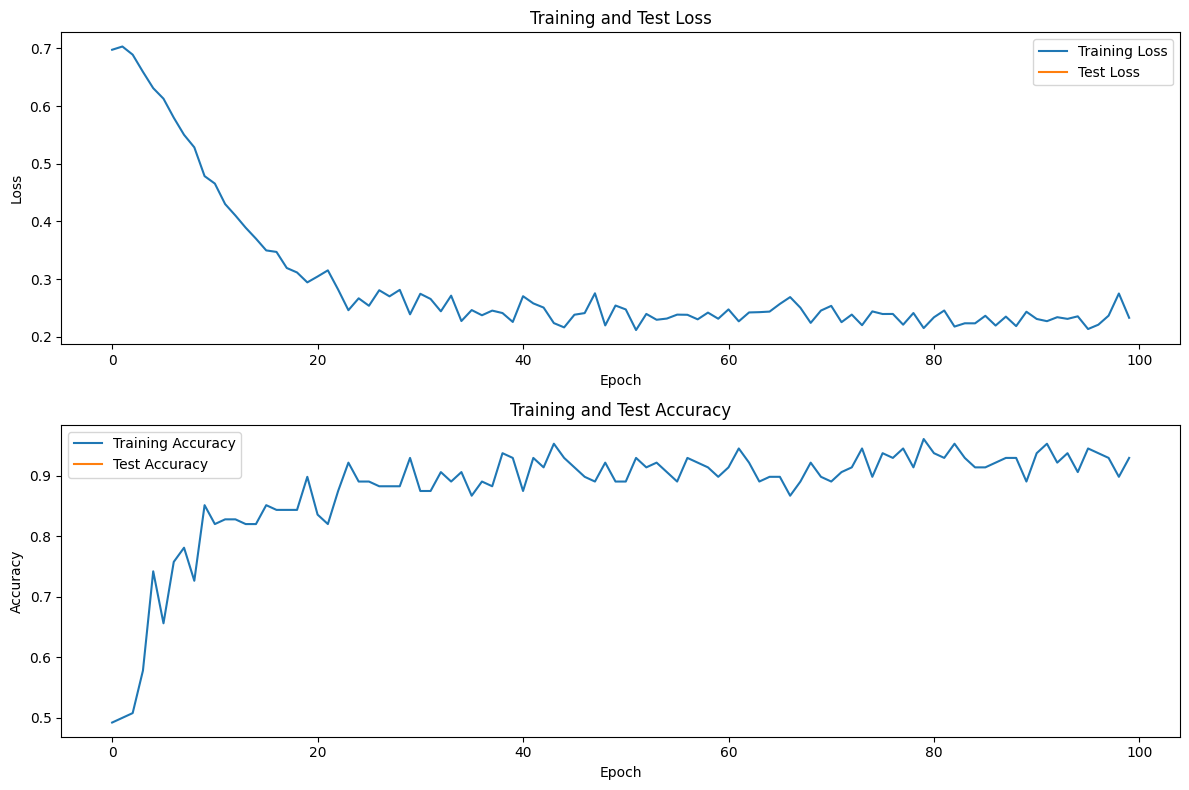

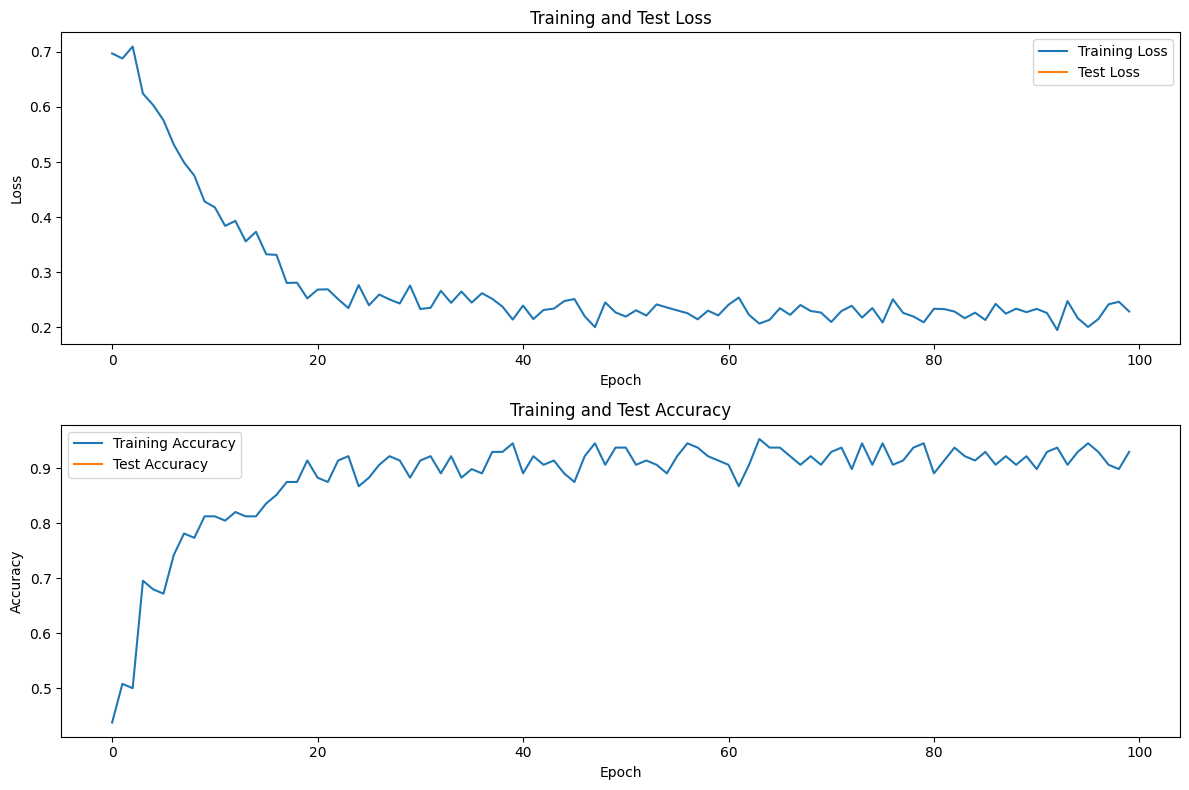

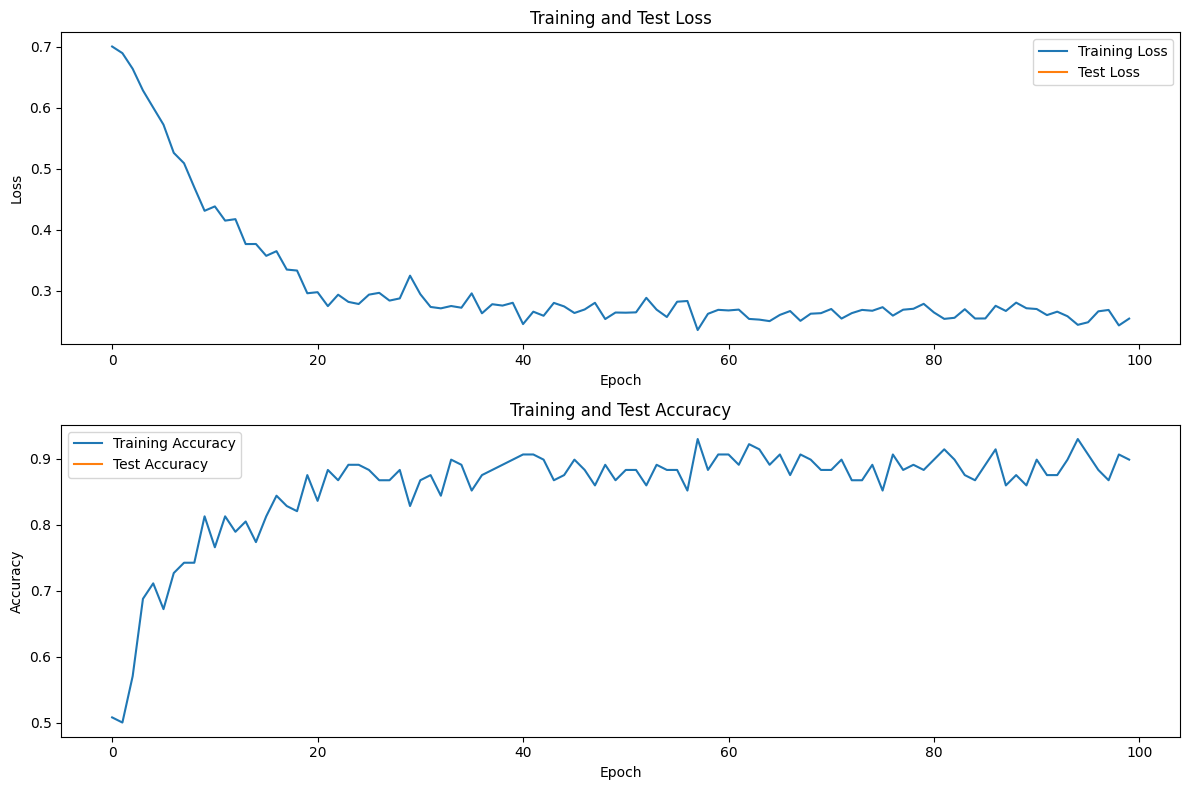

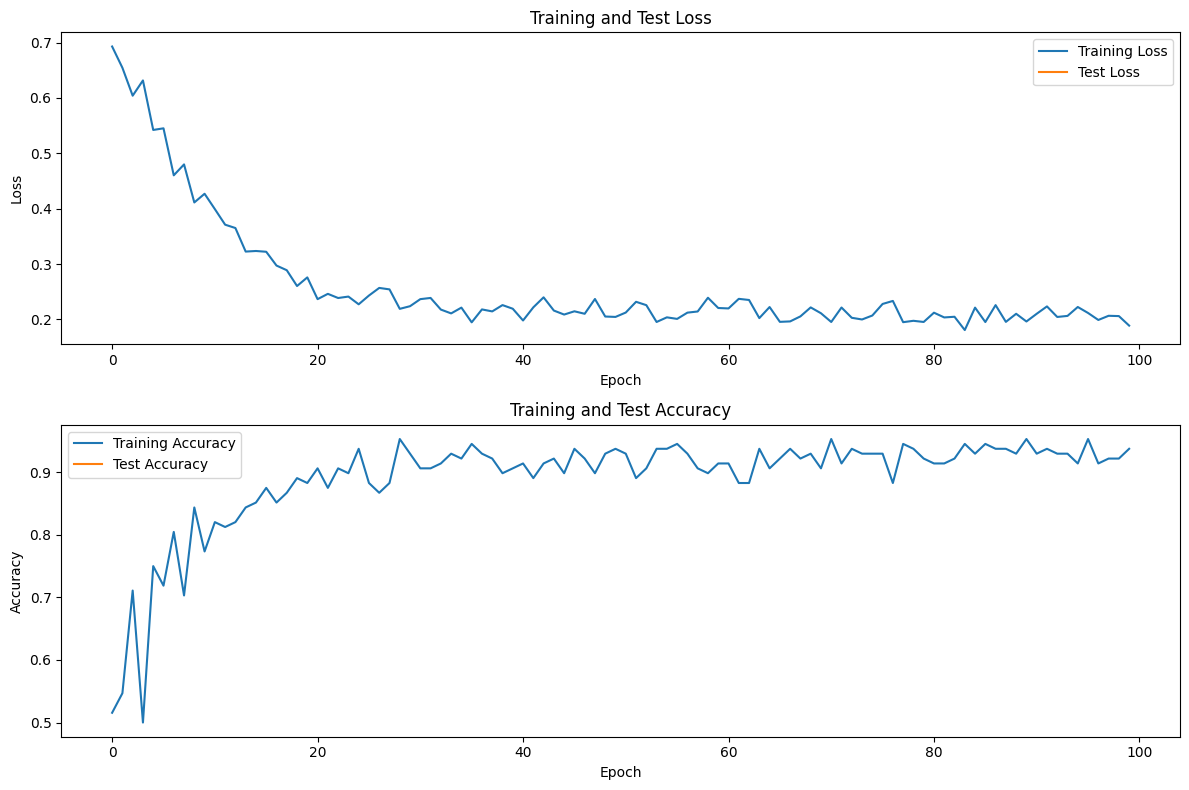

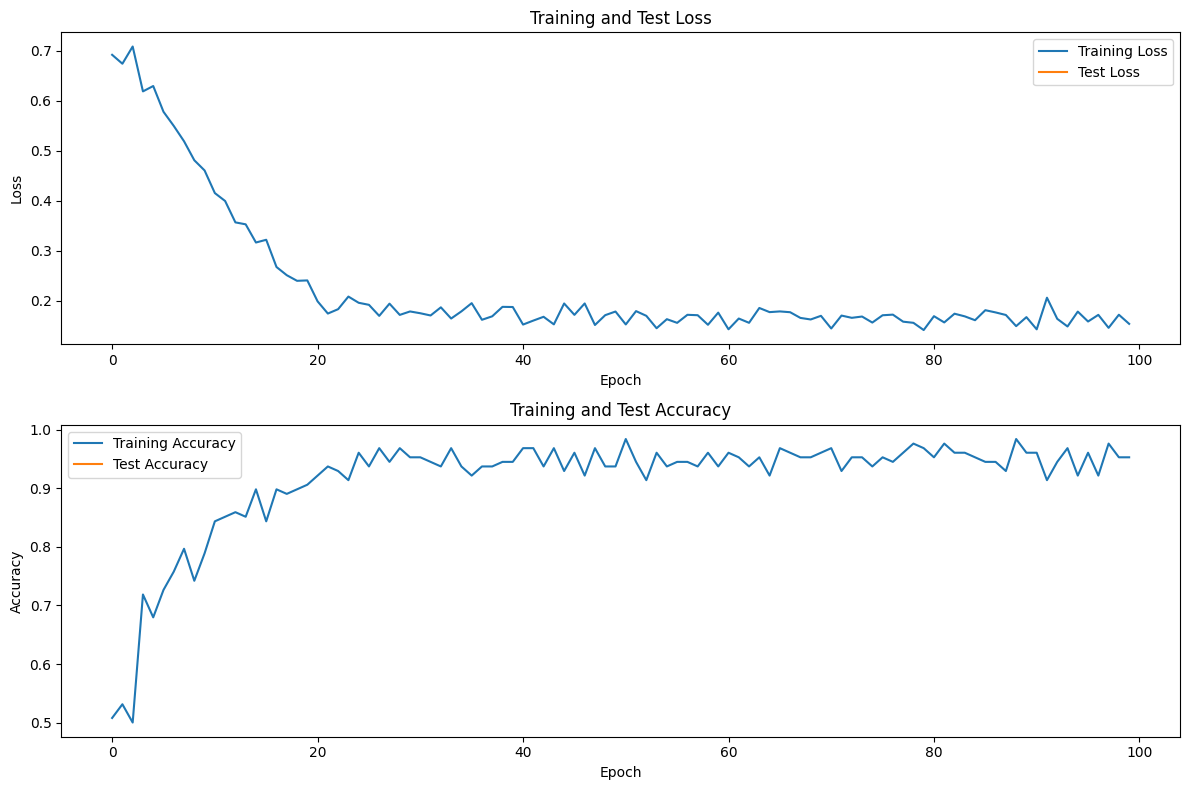

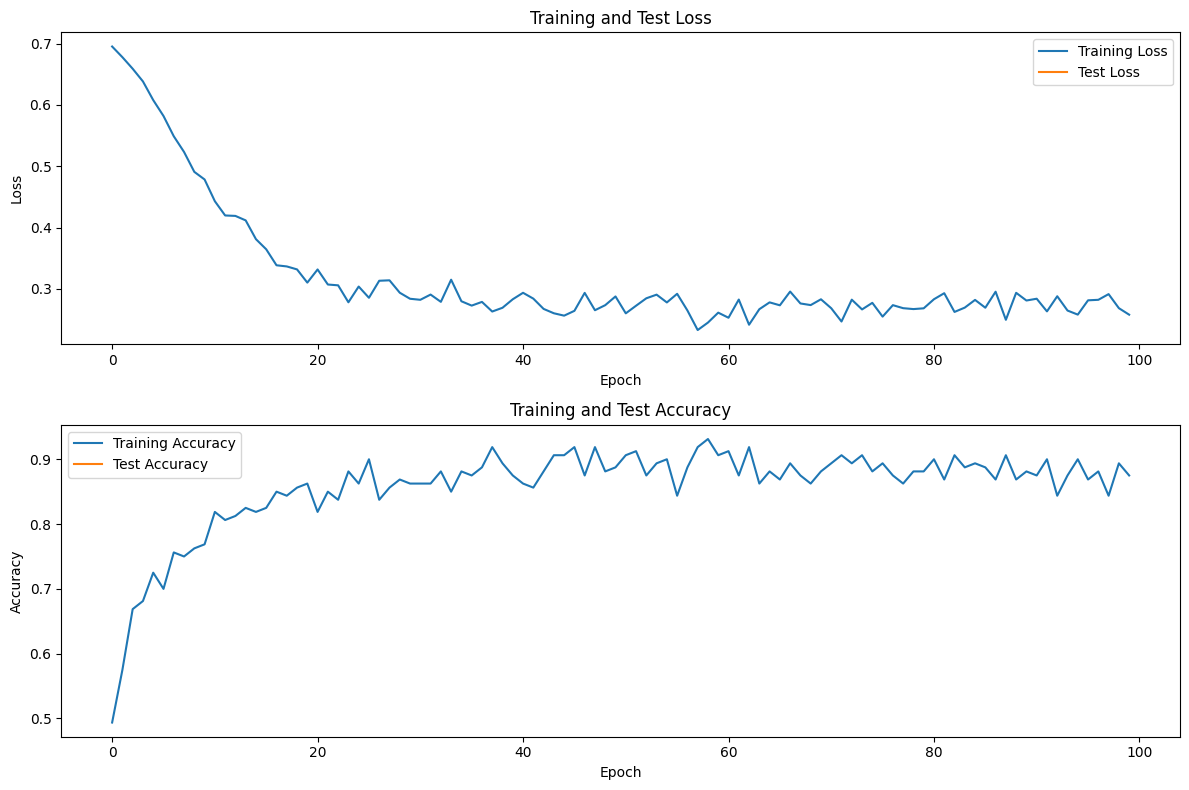

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=CNNClassifier(num_classes=2, num_features=150),
             param_grid={'lr': [0.0001, 0.0005, 0.001]}, scoring='accuracy')

In [13]:

#hyperparamètres
param_grid = {'lr': [0.0001, 0.0005, 0.001]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# GridSearchCV pour la recherche d'hyperparamètres
grid_search = GridSearchCV(estimator=cnn_classifier, param_grid=param_grid, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)



Meilleur taux d apprentissage : 0.0005


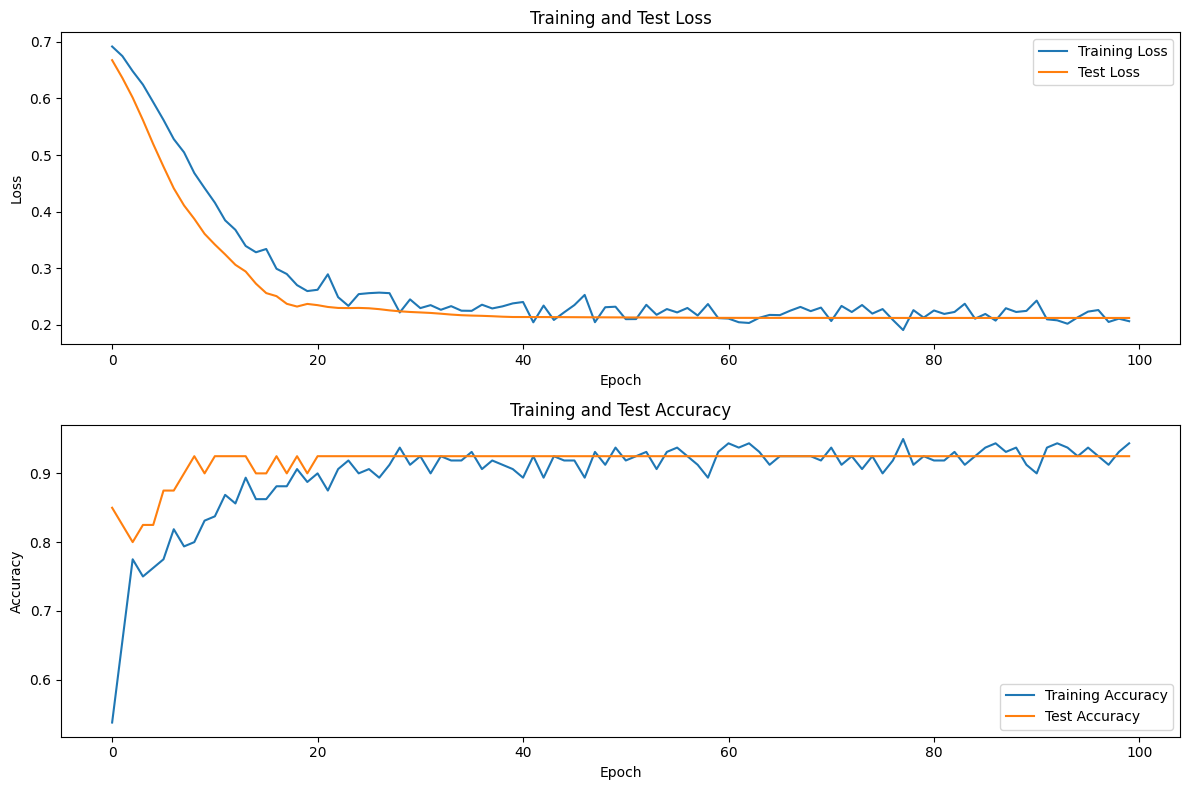

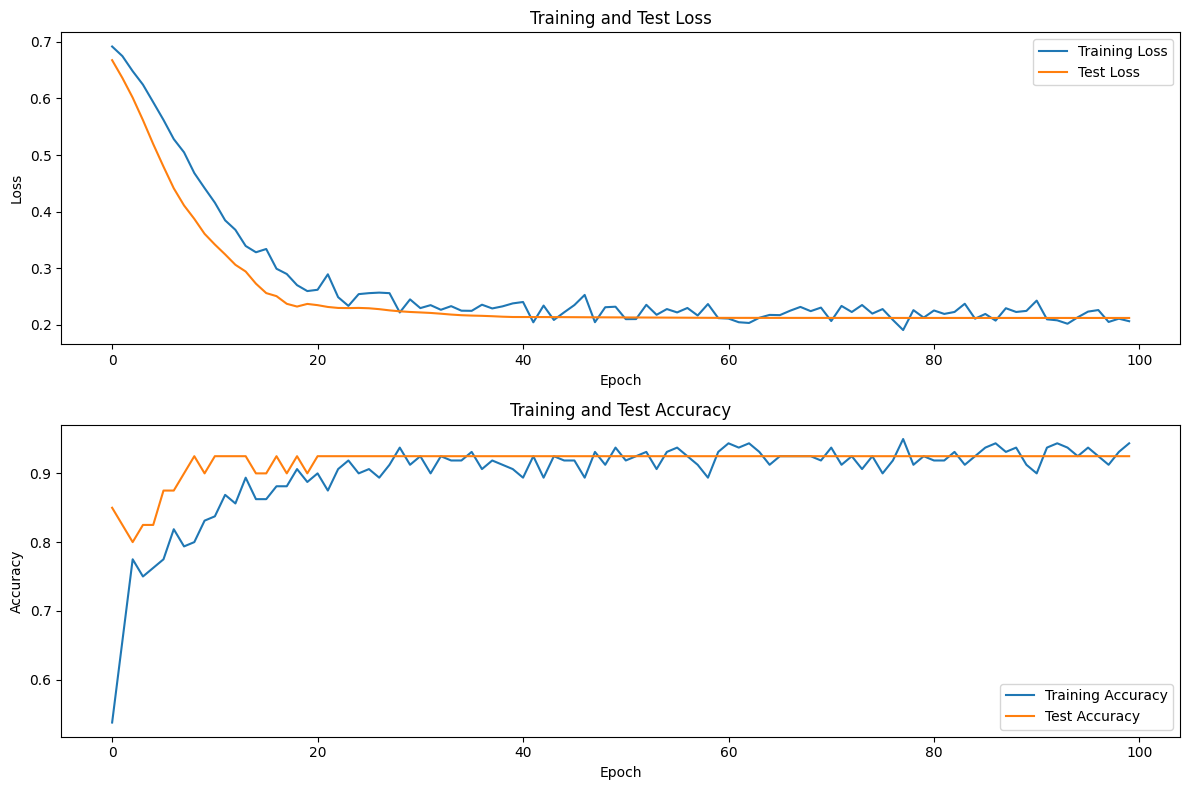

In [14]:

num_features = X_train.shape[2]
num_classes = len(set(y_train))

# Best hyperparameters
print(f'Meilleur taux d apprentissage : {grid_search.best_params_["lr"]}')
best_lr = grid_search.best_params_["lr"]

best_model = CNNClassifier(num_features=num_features, num_classes=num_classes, lr=best_lr)
best_model.fit(X_train, y_train, X_test=X_test, y_test=y_test, num_epochs=100, patience=10)

best_model.plot_loss_accuracy()


Unbalanced Time series

In [15]:
def make_dataset_imbalanced(X, y, class_to_reduce=0, reduction_factor=0.1):
    """
    Reduces the number of samples in the specified class by the reduction factor.

    Parameters:
    X (np.array): Feature data.
    y (np.array): Labels.
    class_to_reduce (int): The class whose samples are to be reduced.
    reduction_factor (float): The fraction of the class_to_reduce samples to keep (0 < reduction_factor <= 1).

    Returns:
    (np.array, np.array): The imbalanced features and labels.
    """
    # Indices of the class to reduce and the other class
    reduce_indices = np.where(y == class_to_reduce)[0]
    other_indices = np.where(y != class_to_reduce)[0]

    # Randomly select a subset of the class to reduce
    reduced_indices = np.random.choice(reduce_indices, int(len(reduce_indices) * reduction_factor), replace=False)

    # Combine the reduced class indices with the other class indices
    new_indices = np.concatenate([reduced_indices, other_indices])
    np.random.shuffle(new_indices)  # Shuffle the indices to mix the classes

    # Create the new imbalanced dataset
    X_imbalanced = X[new_indices]
    y_imbalanced = y[new_indices]

    return X_imbalanced, y_imbalanced

In [16]:
X_train_reduced, y_train_reduced = gpds[2], gpds[-1]
X_train_reduced.shape, y_train_reduced.shape

((88, 1, 150), (88,))

In [17]:
y_train_reduced, y_train_reduced.sum()

(array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]),
 80)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_reduced_norm = scaler.fit_transform(X_train_reduced.reshape(X_train_reduced.shape[0], -1))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0], -1))


X_train_reduced_norm = X_train_reduced_norm.reshape(X_train_reduced_norm.shape[0], 1, -1)
X_test_norm = X_test_norm.reshape(X_test_norm.shape[0], 1, -1)



In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
class SimpleCNN1(nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.25):
        super(SimpleCNN1, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout_rate)


        dummy_x = torch.zeros(1, 1, num_features)
        dummy_x = self.pool(F.relu(self.conv1(dummy_x)))
        dummy_x = self.pool(F.relu(self.conv2(dummy_x)))
        self._to_linear = dummy_x.numel()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._to_linear)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [20]:
from sklearn.utils.class_weight import compute_class_weight
class CNNClassifier1(BaseEstimator, ClassifierMixin):
    def __init__(self, num_features=None, num_classes=None, lr=0.001, weight_decay=0):
        self.lr = lr
        self.num_features = num_features
        self.num_classes = num_classes
        self.weight_decay = weight_decay
        if num_features is not None and num_classes is not None:
            self.model = SimpleCNN1(num_features, num_classes)
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.1)
        else:
            self.model = None
            self.optimizer = None
            self.scheduler = None

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_reduced), y=y_train_reduced)
        class_weights_tensor = torch.FloatTensor(class_weights).to(device)

# Use of the class weights in the loss function
        self.criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.test_loss_history = []
        self.test_accuracy_history = []

    def fit(self, X, y, X_test=None, y_test=None, num_epochs=100, patience=10):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)
        X_test_tensor = torch.FloatTensor(X_test) if X_test is not None else None
        y_test_tensor = torch.LongTensor(y_test) if y_test is not None else None
        best_val_loss = float('inf')
        best_val_accuracy = 0
        best_epoch = -1
        epochs_no_improve = 0

        for epoch in range(num_epochs):
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == y_tensor).sum().item()
            train_accuracy = correct / y_tensor.size(0)
            self.train_loss_history.append(loss.item())
            self.train_accuracy_history.append(train_accuracy)

            if X_test_tensor is not None and y_test_tensor is not None:
                self.model.eval()
                with torch.no_grad():
                    test_outputs = self.model(X_test_tensor)
                    test_loss = self.criterion(test_outputs, y_test_tensor)
                    _, predicted = torch.max(test_outputs.data, 1)
                    correct = (predicted == y_test_tensor).sum().item()
                    test_accuracy = correct / y_test_tensor.size(0)
                    self.test_loss_history.append(test_loss.item())
                    self.test_accuracy_history.append(test_accuracy)

                    if test_loss.item() < best_val_loss:
                        best_val_loss = test_loss.item()
                        best_val_accuracy = test_accuracy
                        best_epoch = epoch
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1
                        if epochs_no_improve >= patience:
                            print(f'Early stopping at epoch {epoch+1}. Best validation accuracy was {best_val_accuracy} at epoch {best_epoch+1}')
                            break

        self.plot_loss_accuracy()

    def predict(self, X):
        X_tensor = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            return predicted.numpy()

    def plot_loss_accuracy(self):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(self.train_loss_history, label='Training Loss')
        plt.plot(self.test_loss_history, label='Test Loss')
        plt.title('Training and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(self.train_accuracy_history, label='Training Accuracy')
        plt.plot(self.test_accuracy_history, label='Test Accuracy')
        plt.title('Training and Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

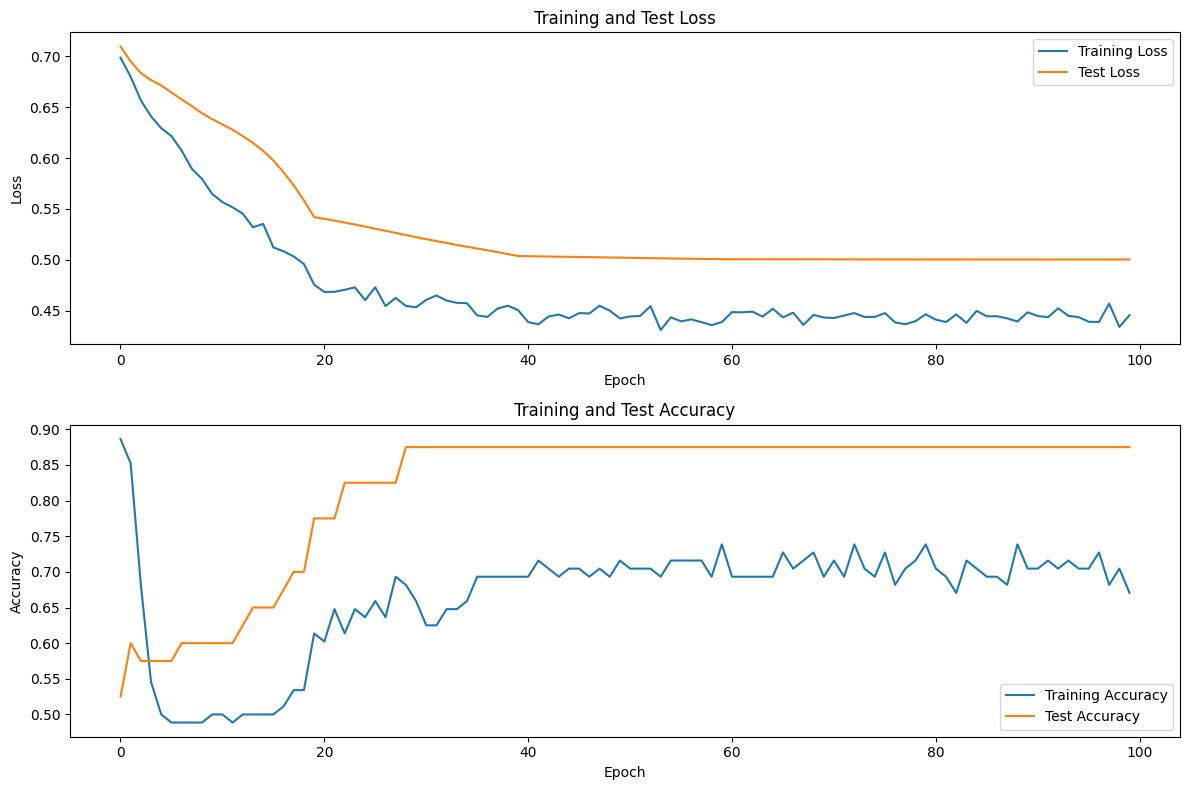

In [21]:
num_features = X_train_reduced_norm.shape[-1]
num_classes = len(set(y_train))
num_epochs=50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_classifier = CNNClassifier1(
    num_features=X_train_reduced_norm.shape[-1],
    num_classes=num_classes,
    lr=0.0001,
    weight_decay=1e-4
)

cnn_classifier.fit(X_train_reduced_norm, y_train_reduced, X_test=X_test_norm, y_test=y_test, num_epochs=100, patience=10)

In [22]:
print(cnn_classifier.test_accuracy_history)

[0.525, 0.6, 0.575, 0.575, 0.575, 0.575, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.625, 0.65, 0.65, 0.65, 0.675, 0.7, 0.7, 0.775, 0.775, 0.775, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875]


Réequilibrage avec SMOTE

In [23]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced.reshape(X_train_reduced.shape[0],X_train_reduced.shape[-1]), y_train_reduced)
X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], 1, -1)
X_train_smote_norm = scaler.fit_transform(X_train_smote.reshape(X_train_smote.shape[0], -1))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0], -1))
X_train_smote_norm = X_train_smote_norm.reshape(X_train_smote.shape[0], 1, -1)
X_test_norm = X_test_norm.reshape(X_test_norm.shape[0], 1, -1)
print(X_train_smote_norm.shape, X_test_norm.shape)
y_train_smote.sum() ## data is again BALANCED

(160, 1, 150) (40, 1, 150)


80

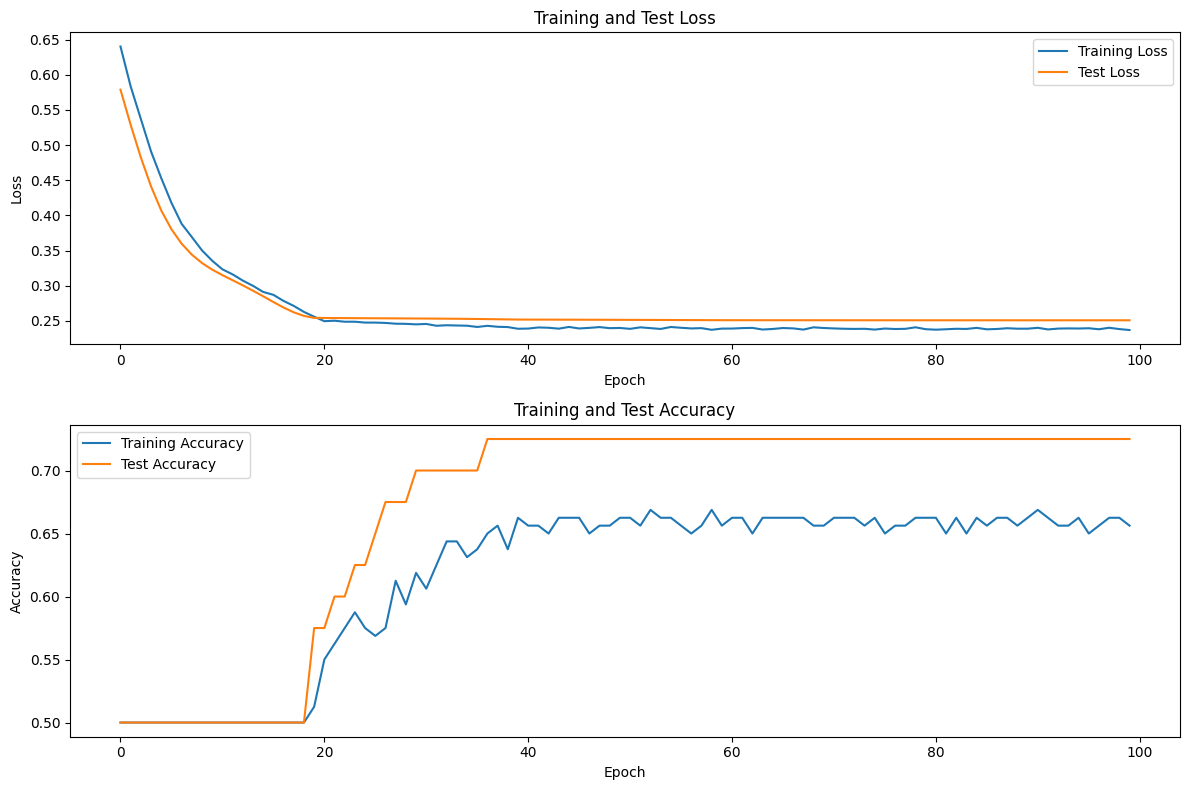

In [24]:
num_features = X_train_smote_norm.shape[-1] # This is the number of features in your dataset
num_classes = len(set(y_train))  # This is the number of classes in your dataset
num_epochs=50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_classifier = CNNClassifier1(
    num_features=X_train_reduced_norm.shape[-1],
    num_classes=num_classes,
    lr=0.0001,  # Un taux d'apprentissage plus faible
    weight_decay=1e-4  # Régularisation L2
)

cnn_classifier.fit(X_train_smote_norm, y_train_smote, X_test=X_test_norm, y_test=y_test, num_epochs=100, patience=10)

In [25]:
print(max(cnn_classifier.test_accuracy_history))

0.725


In [26]:
print(X_train_reduced_norm.shape)

(88, 1, 150)


In [27]:
print(y_train.shape)

(160,)


In [28]:
print(y_train_reduced)

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 1 0 1]


**WITH IMAGES**

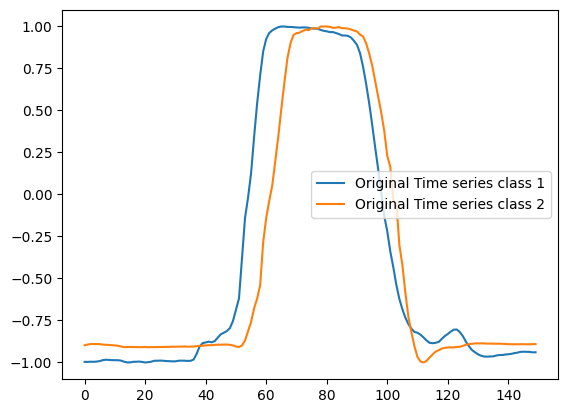

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np


import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

"""# Dataset"""

X, y = load_classification(name="GunPoint")
y_reduced = y.copy()
X_reduced = X.copy()

"""## Convert time series into images"""

from scipy import signal

#Normalise
a=-1
b=1
X_normalized = []
for el in X :
  max = np.max(el)
  min = np.min(el)
  X_normalized.append((el - min) / (max - min) * (b - a) + a)

time_series_class_2 = X_normalized[0]
time_series_class_1 = X_normalized[2]


plt.plot(time_series_class_1[0], label=f'Original Time series class 1')
plt.plot(time_series_class_2[0], label=f'Original Time series class 2')
plt.legend()

!pip install -U pyts
from pyts.image import GramianAngularField

np.shape(X_normalized)

# Set parameters for Gramian Angular Field
image_size = 1.0
sample_range = (-1, 1)
method = 'summation'  # Other options: 'difference', 'product', 'double_summation'

# Create Gramian Angular Field transformer
gaf = GramianAngularField(image_size=image_size, sample_range=sample_range, method=method)

# Transform time series to GAF
gaf_images_X = []
for el in X_normalized:
  gaf_images_X.append(gaf.fit_transform(el))
gaf_image_class_1 = gaf_images_X[0]
gaf_image_class_2 = gaf_images_X[2]




(160, 150, 150) (40, 150, 150)


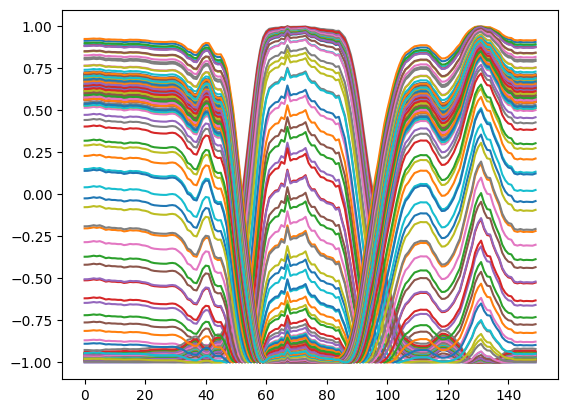

In [30]:
def transform_to_gasf(series):
    normalized_series = (series - np.min(series)) / (np.max(series) - np.min(series))
    gasf_transformer = GramianAngularField(image_size=normalized_series.shape[0], method='summation')
    gasf_image = gasf_transformer.fit_transform(normalized_series.reshape(1, -1))
    return gasf_image[0]

# Transform the entire dataset
X_train_gasf = np.array([transform_to_gasf(sample[0, :]) for sample in X_train])
X_test_gasf = np.array([transform_to_gasf(sample[0, :]) for sample in X_test])
print(X_train_gasf.shape , X_test_gasf.shape)
plt.plot(X_train_gasf[0])

In [31]:

X_train_tensor = torch.FloatTensor(X_train_gasf).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_gasf).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.LongTensor(y_test)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

class CNN2D(nn.Module):
    def __init__(self, num_classes, image_size):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Forward a dummy input to dynamically compute fc1_input_size
        dummy_input = torch.zeros(1, 1, image_size, image_size)
        dummy_output = self.conv1(dummy_input)
        dummy_output = self.pool(dummy_output)
        dummy_output = self.conv2(dummy_output)
        dummy_output = self.pool(dummy_output)
        fc1_input_size = int(np.prod(dummy_output.size()[1:]))

        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")






In [33]:
image_size = X_train_gasf.shape[1]
num_classes = len(np.unique(y_train))

model = CNN2D(num_classes=num_classes, image_size=image_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [34]:
print(X_train_gasf.size
      )

3600000


In [35]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # Evaluate on test set
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on test set: {100 * correct / total}%")


Epoch 1, Loss: 1.0827269315719605
Accuracy on test set: 50.0%
Epoch 2, Loss: 0.68106130361557
Accuracy on test set: 70.0%
Epoch 3, Loss: 0.6045711159706115
Accuracy on test set: 90.0%
Epoch 4, Loss: 0.42580999732017516
Accuracy on test set: 92.5%
Epoch 5, Loss: 0.24764842689037322
Accuracy on test set: 90.0%
Epoch 6, Loss: 0.1353190690279007
Accuracy on test set: 95.0%
Epoch 7, Loss: 0.06490016020834447
Accuracy on test set: 97.5%
Epoch 8, Loss: 0.03905210494995117
Accuracy on test set: 95.0%
Epoch 9, Loss: 0.022688791435211898
Accuracy on test set: 97.5%
Epoch 10, Loss: 0.007424512691795826
Accuracy on test set: 97.5%


UNBALANCED IMAGES

In [36]:
X_train_reduced, y_train_reduced = gpds[2], gpds[-1]
X_train_reduced.shape, y_train_reduced.shape

((88, 1, 150), (88,))

In [37]:
y_train_reduced, y_train_reduced.sum()

(array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]),
 80)

(88, 150, 150)


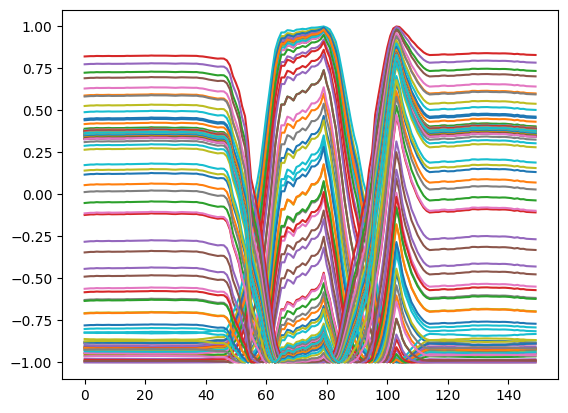

In [38]:

X_train_reduced_gasf = np.array([transform_to_gasf(sample[0, :]) for sample in X_train_reduced])
print(X_train_reduced_gasf.shape)
plt.plot(X_train_reduced_gasf[0])

In [39]:
# Convertir en tenseurs PyTorch
X_train_reduced_tensor = torch.FloatTensor(X_train_reduced_gasf).unsqueeze(1)  # Ajouter la dimension des canaux
y_train_reduced_tensor = torch.LongTensor(y_train_reduced)

# Création de l'ensemble de données et du chargeur de données
train_dataset_reduced = TensorDataset(X_train_reduced_tensor, y_train_reduced_tensor)
train_loader_reduced = DataLoader(train_dataset_reduced, batch_size=32, shuffle=True)



In [40]:
model = CNN2D(num_classes=2, image_size=X_train_reduced_gasf.shape[2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
train_loss_history = []
test_loss_history = []
test_accuracy_history = []


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
num_epochs=100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_reduced:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss_history.append(running_loss / len(train_loader_reduced))

    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    test_loss_history.append(test_loss / len(test_loader))
    test_accuracy_history.append(100 * correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_history[-1]}, Test Loss: {test_loss_history[-1]}, Accuracy: {test_accuracy_history[-1]}%")


Epoch 1, Train Loss: 1.1573371887207031, Test Loss: 6.128221273422241, Accuracy: 50.0%
Epoch 2, Train Loss: 0.5897543529669443, Test Loss: 1.6714388728141785, Accuracy: 50.0%
Epoch 3, Train Loss: 0.28196556866168976, Test Loss: 0.8907606601715088, Accuracy: 50.0%
Epoch 4, Train Loss: 0.3038899153470993, Test Loss: 1.1157242357730865, Accuracy: 50.0%
Epoch 5, Train Loss: 0.24319827059904733, Test Loss: 1.7102835178375244, Accuracy: 50.0%
Epoch 6, Train Loss: 0.23010503749052683, Test Loss: 1.237765610218048, Accuracy: 50.0%
Epoch 7, Train Loss: 0.17875057955582938, Test Loss: 0.8189587891101837, Accuracy: 50.0%
Epoch 8, Train Loss: 0.1584523618221283, Test Loss: 0.7424427568912506, Accuracy: 50.0%
Epoch 9, Train Loss: 0.12561841060717902, Test Loss: 0.6718421280384064, Accuracy: 57.5%
Epoch 10, Train Loss: 0.10103236138820648, Test Loss: 0.5656846463680267, Accuracy: 77.5%
Epoch 11, Train Loss: 0.09615555902322133, Test Loss: 0.572698563337326, Accuracy: 77.5%
Epoch 12, Train Loss: 0.07

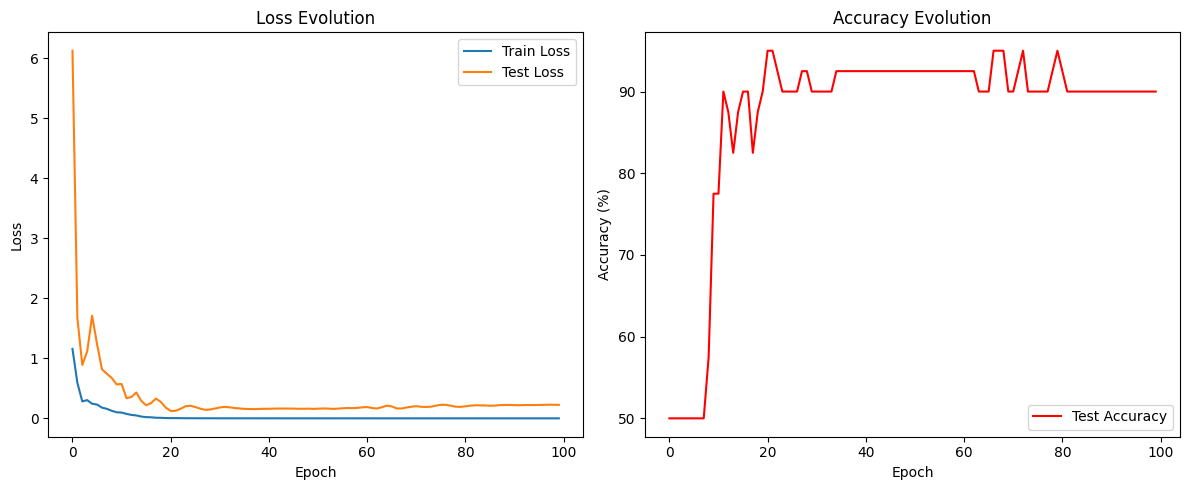

In [43]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy_history, color='red', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution')
plt.legend()

plt.tight_layout()
plt.show()


Rééquilibrer avec les images générées

In [44]:
gen_imgs = np.load('concatenated_images_UpsampleGAN.npy')
gen_ohe_labels = np.load('concatenated_labels_UpsampleGAN.npy')
gen_imgs.shape , gen_ohe_labels.shape

((200, 150, 150), (200, 2))

In [45]:
def transform_labels(gen_ohe_labels):
    return np.where(gen_ohe_labels == 1)[-1]

gen_labels = transform_labels(gen_ohe_labels)
print(gen_labels)
gen_imgs.shape , gen_labels.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


((200, 150, 150), (200,))

In [46]:
def random_idx_selection(gen_labels,seed=0, cls = 0, amount = 72):
    indices_class_x = np.where(gen_labels == cls)[0]
    np.random.seed(seed)


    selected_indices = np.random.choice(indices_class_x, size=amount, replace=False)
    assert(selected_indices.all() < len(gen_labels)/2)
    return selected_indices

selected_idx = random_idx_selection(gen_labels)
selected_idx

array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
       24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
       51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
       59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
       14, 89, 19, 29])

In [47]:
# rebalacing the vector
selected_elements = gen_imgs[selected_idx]
selected_labels = gen_labels[selected_idx]
X_train_rebalanced = np.concatenate((X_train_reduced_gasf,selected_elements))
y_train_rebalanced = np.concatenate((y_train_reduced,selected_labels))
X_train_rebalanced.shape , y_train_rebalanced.shape, y_train_rebalanced.sum()

((160, 150, 150), (160,), 80)

In [48]:
model = CNN2D(num_classes=2, image_size=X_train_rebalanced.shape[2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
train_loss_history = []
test_loss_history = []
test_accuracy_history = []


In [50]:
# Convertir en tenseurs PyTorch
X_train_rebalanced_tensor = torch.FloatTensor(X_train_rebalanced).unsqueeze(1)  # Ajouter la dimension des canaux
y_train_rebalanced_tensor = torch.LongTensor(y_train_rebalanced)

# Création de l'ensemble de données et du chargeur de données
train_dataset_rebalanced = TensorDataset(X_train_rebalanced_tensor, y_train_rebalanced_tensor)
train_loader_rebalanced = DataLoader(train_dataset_rebalanced, batch_size=32, shuffle=True)


In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
num_epochs=100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_rebalanced:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss_history.append(running_loss / len(train_loader_rebalanced))

    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    test_loss_history.append(test_loss / len(test_loader))
    test_accuracy_history.append(100 * correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_history[-1]}, Test Loss: {test_loss_history[-1]}, Accuracy: {test_accuracy_history[-1]}%")


Epoch 1, Train Loss: 0.8936156451702117, Test Loss: 0.5161288380622864, Accuracy: 67.5%
Epoch 2, Train Loss: 0.40830582976341245, Test Loss: 0.6448110938072205, Accuracy: 72.5%
Epoch 3, Train Loss: 0.22774205952882767, Test Loss: 0.4824768006801605, Accuracy: 77.5%
Epoch 4, Train Loss: 0.13496542274951934, Test Loss: 0.5945825129747391, Accuracy: 77.5%
Epoch 5, Train Loss: 0.0906062051653862, Test Loss: 0.45370088517665863, Accuracy: 82.5%
Epoch 6, Train Loss: 0.06269926428794861, Test Loss: 0.19709715992212296, Accuracy: 92.5%
Epoch 7, Train Loss: 0.030429036356508732, Test Loss: 0.21918858587741852, Accuracy: 87.5%
Epoch 8, Train Loss: 0.024758306611329318, Test Loss: 0.10118608549237251, Accuracy: 92.5%
Epoch 9, Train Loss: 0.021004602685570715, Test Loss: 0.08940814808011055, Accuracy: 92.5%
Epoch 10, Train Loss: 0.015626851795241238, Test Loss: 0.09270204044878483, Accuracy: 92.5%
Epoch 11, Train Loss: 0.004477603349369019, Test Loss: 0.058617311995476484, Accuracy: 95.0%
Epoch 12

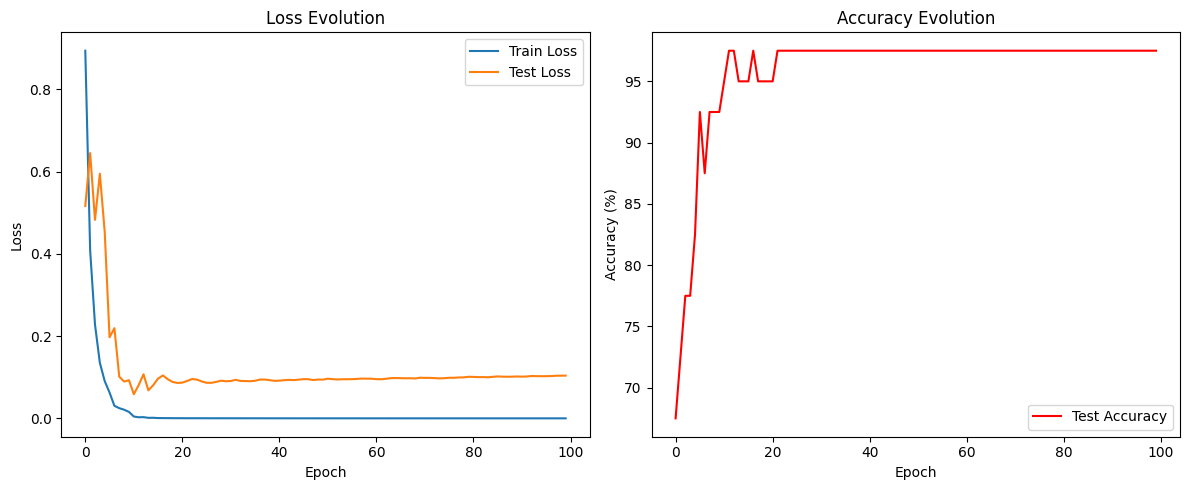

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy_history, color='red', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution')
plt.legend()

plt.tight_layout()
plt.show()


**FaultDetectionA**

In [53]:
X, y, metadata = load_classification(name="FaultDetectionA",return_metadata=True)
y = np.array([int(i)-1 for i in y])
X.shape , y.shape

((13640, 1, 5120), (13640,))

In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [55]:
print(np.unique(y_train))

[-1  0  1]


In [56]:
# normalizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0], -1))
X_train_norm = X_train_norm.reshape(X_train.shape[0], 1, -1)
X_test_norm = X_test_norm.reshape(X_test.shape[0], 1, -1)
X_train_norm.shape, X_test_norm.shape

((10912, 1, 5120), (2728, 1, 5120))

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNN(nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1).to(device)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2).to(device)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1).to(device)
        self.dropout = nn.Dropout(dropout_rate).to(device)
        dummy_x = torch.zeros(1, 1, num_features, device=device)
        dummy_x = self.pool(F.relu(self.conv1(dummy_x)))
        dummy_x = self.pool(F.relu(self.conv2(dummy_x)))
        self._to_linear = dummy_x.numel()
        self.fc1 = nn.Linear(self._to_linear, 128).to(device)
        self.fc2 = nn.Linear(128, num_classes).to(device)

    def forward(self, x):
        x = x.to(device)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._to_linear)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_features=None, num_classes=None, lr=0.001):
        self.lr = lr
        self.num_features = num_features
        self.num_classes = num_classes
        if num_features is not None and num_classes is not None:
            self.model = SimpleCNN(num_features, num_classes)
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.1)
        else:
            self.model = None
            self.optimizer = None
            self.scheduler = None
        self.criterion = nn.CrossEntropyLoss()
        # Initialize the histories
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.test_loss_history = []
        self.test_accuracy_history = []

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        if self.model is None:
            self.model = SimpleCNN(self.num_features, self.num_classes)
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.1)
        return self



    def fit(self, X, y, X_test=None, y_test=None, num_epochs=100, batch_size=64):
     train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X), torch.LongTensor(y))
     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
     test_loss = None
     test_accuracy = None

     if X_test is not None and y_test is not None:
        test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

     for epoch in range(num_epochs):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        self.train_loss_history.append(train_loss)
        self.train_accuracy_history.append(train_accuracy)

        if X_test is not None and y_test is not None:
            self.model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            test_loss /= len(test_loader)
            test_accuracy = 100 * correct / total
            self.test_loss_history.append(test_loss)
            self.test_accuracy_history.append(test_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,'
              f' Test Loss: {"{:.4f}".format(test_loss) if test_loss is not None else "N/A"},'
              f' Test Accuracy: {"{:.2f}".format(test_accuracy) if test_accuracy is not None else "N/A"}%')

     print('Finished Training')



    def predict(self, X):
        X_tensor = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            # Map predictions back to original labels
            inverse_label_mapping = {0: -1, 1: 0, 2: 1}
            predicted_labels = [inverse_label_mapping[pred.item()] for pred in predicted]
            return predicted_labels

    def plot_loss_accuracy(self):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(self.train_loss_history, label='Training Loss')
        plt.plot(self.test_loss_history, label='Test Loss')
        plt.title('Training and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(self.train_accuracy_history, label='Training Accuracy')
        plt.plot(self.test_accuracy_history, label='Test Accuracy')
        plt.title('Training and Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


print( X_train_norm.shape)

In [58]:
num_features=X_train_norm.shape[2]
model=CNNClassifier(num_features,3)
y_train=y_train+1
y_test=y_test+1

model.fit(X_train_norm, y_train,X_test_norm,y_test, num_epochs=10, batch_size=32)

Epoch 1, Train Loss: 0.4830, Train Accuracy: 83.47%, Test Loss: 3.9862, Test Accuracy: 45.45%
Epoch 2, Train Loss: 0.0821, Train Accuracy: 96.88%, Test Loss: 6.8792, Test Accuracy: 45.45%
Epoch 3, Train Loss: 0.0438, Train Accuracy: 98.39%, Test Loss: 9.2256, Test Accuracy: 45.45%
Epoch 4, Train Loss: 0.0384, Train Accuracy: 98.54%, Test Loss: 10.9061, Test Accuracy: 45.45%
Epoch 5, Train Loss: 0.0188, Train Accuracy: 99.38%, Test Loss: 11.2411, Test Accuracy: 45.45%
Epoch 6, Train Loss: 0.0156, Train Accuracy: 99.53%, Test Loss: 13.0057, Test Accuracy: 45.53%
Epoch 7, Train Loss: 0.0073, Train Accuracy: 99.82%, Test Loss: 16.7309, Test Accuracy: 45.45%
Epoch 8, Train Loss: 0.0095, Train Accuracy: 99.80%, Test Loss: 17.7511, Test Accuracy: 45.45%
Epoch 9, Train Loss: 0.0216, Train Accuracy: 99.40%, Test Loss: 15.6300, Test Accuracy: 45.45%
Epoch 10, Train Loss: 0.0140, Train Accuracy: 99.54%, Test Loss: 16.4951, Test Accuracy: 45.82%
Finished Training
